In [ ]:
#default_exp transforms

In [ ]:
#export
from fastai2.vision.all import *

# Download dataset

In [ ]:
path = untar_data(URLs.CIFAR)

In [ ]:
fnames = get_image_files(path/'train')

In [ ]:
base_pipe = [PILImage.create,ToTensor,IntToFloatTensor]
tls = TfmdLists(fnames,Pipeline(base_pipe))

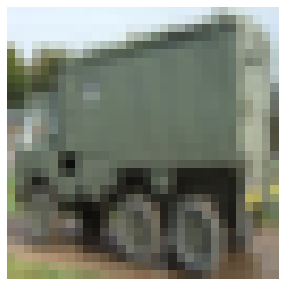

In [ ]:
tls[100].show(figsize=(5,5));

# Min-Max Scale

In [ ]:
#export
def min_max_scale(x:Tensor,min=0,max=1):
  return min + ((x-x.min()) * (max-min)) / (x.max()-x.min())

# Global Contrast Normalization

reference: Yoshua Bengio's Deep Learning book (section 12.2.1.1 pg.442)

Prevents images from having varying amount of contrast. With s=1 and $\lambda$=0, it's almost equivalent to z-score normalization. I've shown the effects of modifying these parameters. (Sigmoid is applied for visualization purpose, it's not the part of Transform)

In [ ]:
#export transforms
class GlobalContrastNorm(Transform):
  """prevents images from having varying contrast
  reference: [Maxout Networks](https://arxiv.org/abs/1302.4389)
  decodes used for `show_batch`.
  Currently it's designed to work with batch of RGB
  images only
  """
  order=11 # Need to be applied after IntToFloatTensor
  def __init__(self,s=1,eps=1e-8,lmbda=0.):
    store_attr(self,'s,eps,lmbda')

  def encodes(self, x:TensorImage):
    contrast = (x.var((1,2,3),keepdim=True)+self.lmbda).sqrt().clamp_(self.eps)
    return self.s * (x - x.mean((1,2,3),keepdim=True)) / contrast

  def decodes(self,x:TensorImage): return min_max_scale(x)

In [ ]:
ds = Datasets(get_image_files(path/'train'),Pipeline(base_pipe[:-1]))
dls = TfmdDL(ds,bs=64,after_item=IntToFloatTensor,device='cuda')

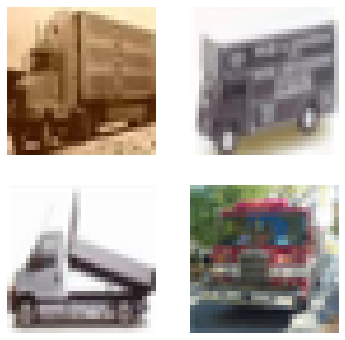

In [ ]:
dls.show_batch(max_n=4)

In [ ]:
dl2 = TfmdDL(ds,bs=64,after_item=IntToFloatTensor,after_batch=[Normalize,GlobalContrastNorm],device='cuda')

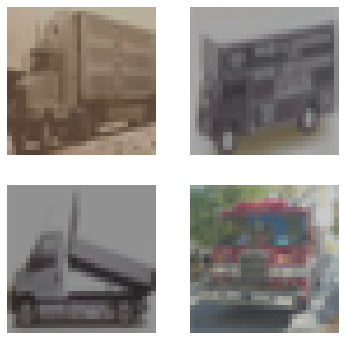

In [ ]:
dl2.show_batch(max_n=4)

# ZCA Whitening

Introduced in [this](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf) paper. Referring [Keras](https://github.com/keras-team/keras-preprocessing/blob/371ca04391566d00d4fea4b347612b1efc146997/keras_preprocessing/image/image_data_generator.py#L984) implementation 

$$W^{ZCA} = U\Lambda^{-\frac{1}{2}}U^T$$

$$z = W^{ZCA} x$$


In [ ]:
eps=1e-6
xb,*_ = dl2.one_batch()

In [ ]:
flat_xb = xb.view(xb.shape[0],-1).cpu()

In [ ]:
flat_xb.T @ flat_xb

tensor([[70.1578, 68.2166, 67.4254,  ..., -0.6393,  0.4334,  0.2891],
        [68.2166, 73.1856, 73.0159,  ..., -0.5086,  0.4051,  0.1820],
        [67.4254, 73.0159, 74.0781,  ..., -0.5918,  0.3568,  0.1739],
        ...,
        [-0.6393, -0.5086, -0.5918,  ..., 67.1251, 66.0800, 64.6320],
        [ 0.4334,  0.4051,  0.3568,  ..., 66.0800, 65.5748, 64.3580],
        [ 0.2891,  0.1820,  0.1739,  ..., 64.6320, 64.3580, 64.7952]])

In [ ]:
sigma = (flat_xb.T @ flat_xb) / flat_xb.shape[0]
u,s,_ = torch.svd(sigma)
s_inv = 1. / torch.sqrt(s)
z = u * s_inv @ u.T

In [ ]:
z_full = z.clone()

In [ ]:
z_full.shape,flat_xb.shape

(torch.Size([3072, 3072]), torch.Size([128, 3072]))

In [ ]:
white_xb = flat_xb @ z

In [ ]:
xb.shape

torch.Size([64, 3, 48, 48])

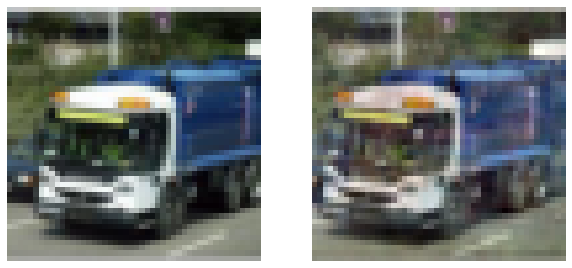

In [ ]:
show_images(L(im,white_xb[0].view(*xb.shape[1:])).map(min_max_scale),figsize=(10,10))

In [ ]:
class ZCA_Whitening(Transform):
  """Apply ZCA Whitening
     $$W^{ZCA} = U\Lambda^{-\frac{1}{2}}U^T$$
     (Caution: Heavy transformation, consider applying beforehand \
     and saving the results)   
  """
  def __init__(self,eps=1e-6,device='cpu'): self.eps,self.device = eps,device
  def encodes(self, x:TensorImage):
    no_batch = mask.dim()==2
    if no_batch: x = x[None]
    f = to_cpu() if self.device=='cpu' else noop
    flat_xb = xb.view(xb.shape[0],-1)
    sigma = (flat_xb.T @ flat_xb) / flat_xb.shape[0]
    u,s,_ = torch.svd(sigma)
    s_inv = 1. / torch.sqrt(s)
    z = u * s_inv @ u.T
  
  def decodes(self, x:TensorImage): return min_max_scale(x)

In [ ]:
dl3 = TfmdDL(ds,bs=32,after_item=IntToFloatTensor,after_batch=GlobalContrastNorm)

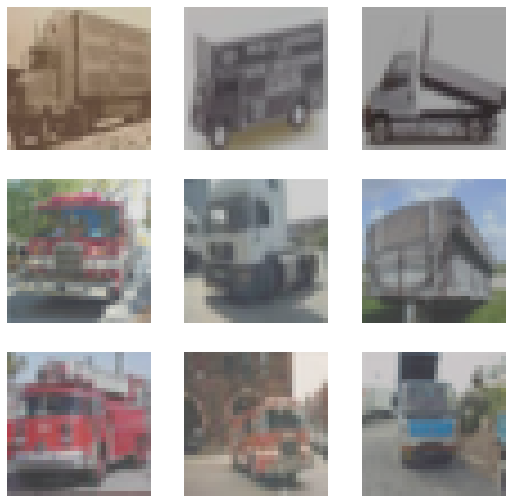

In [ ]:
dl3.show_batch()

# kornia ZCA Whitening

In [ ]:
#@title Unmodified from [kornia.color.zca](https://github.com/kornia/kornia/blob/a2b34d497314e7ed65f114401efdd3cc9ba2077c/kornia/color/zca.py)
%%writefile zca.py

from typing import Tuple, Optional, Union, List
from functools import reduce

import torch
import torch.nn as nn


class ZCAWhitening(nn.Module):
    r"""
    Computes the ZCA whitening matrix transform and the mean vector and applies the transform
    to the data. The data tensor is flattened, and the mean :math:`\mathbf{\mu}`
    and covariance matrix :math:`\mathbf{\Sigma}` are computed from
    the flattened data :math:`\mathbf{X} \in \mathbb{R}^{N \times D}`, where
    :math:`N` is the sample size and :math:`D` is flattened dimensionality
    (e.g. for a tensor with size 5x3x2x2 :math:`N = 5` and :math:`D = 12`). The ZCA whitening
    transform is given by:
    .. math::
        \mathbf{X}_{\text{zca}} = (\mathbf{X - \mu})(US^{-\frac{1}{2}}U^T)^T
    where :math:`U` are the eigenvectors of :math:`\Sigma` and :math:`S` contain the correpsonding
    eigenvalues of :math:`\Sigma`. After the transform is applied, the output is reshaped to same shape.
    args:
        dim (int): Determines the dimension that represents the samples axis. Default = 0
        eps (float) : a small number used for numerial stablility. Default=1e-6
        unbiased (bool): Whether to use the biased estimate of the covariance matrix. Default=False
        compute_inv (bool): Compute the inverse transform matrix. Default=False
        detach_transforms (bool): Detaches gradient from the ZCA fitting. Default=True
    shape:
        - x: :math:`(D_0,...,D_{\text{dim}},...,D_N)` is a batch of N-D tensors.
        - x_whiten: :math:`(D_0,...,D_{\text{dim}},...,D_N)` same shape as input.
    Examples:
        >>> x = torch.tensor([[0,1],[1,0],[-1,0],[0,-1]], dtype = torch.float32)
        >>> zca = kornia.color.ZCAWhitening().fit(x)
        >>> x_whiten = zca(x)
        >>> zca = kornia.color.ZCAWhitening()
        >>> x_whiten = zca(x, include_fit = True) # Includes the fitting step
        >>> x_whiten = zca(x) # Can run now without the fitting set
        >>> # Enable backprop through ZCA fitting process
        >>> zca = kornia.color.ZCAWhitening(detach_transforms = False)
        >>> x_whiten = zca(x, include_fit = True) # Includes the fitting step
    Note:
        This implementation uses :py:meth:`~torch.svd` which yields NaNs in the backwards step
        if the sigular values are not unique. See `here <https://pytorch.org/docs/stable/torch.html#torch.svd>`_ for
        more information.
    References:
        [1] `Stanford PCA & ZCA whitening tutorial <http://ufldl.stanford.edu/tutorial/unsupervised/PCAWhitening/>`_
    """

    def __init__(self, dim: int = 0, eps: float = 1e-6,
                 unbiased: bool = True, detach_transforms: bool = True,
                 compute_inv: bool = False) -> None:

        super(ZCAWhitening, self).__init__()

        self.dim = dim
        self.eps = eps
        self.unbiased = unbiased
        self.detach_transforms = detach_transforms
        self.compute_inv = compute_inv

        self.fitted = False

    def fit(self, x: torch.Tensor):
        r"""
        Fits ZCA whitening matrices to the data.
        args:
            x (torch.Tensor): Input data
        returns:
            ZCAWhiten: returns a fitted ZCAWhiten object instance.
        """

        T, mean, T_inv = zca_mean(x, self.dim, self.unbiased, self.eps, self.compute_inv)

        self.mean_vector: torch.Tensor = mean
        self.transform_matrix: torch.Tensor = T
        if T_inv is None:
            self.transform_inv: Optional[torch.Tensor] = torch.empty([0, ])
        else:
            self.transform_inv = T_inv

        if self.detach_transforms:
            self.mean_vector = self.mean_vector.detach()
            self.transform_matrix = self.transform_matrix.detach()
            self.transform_inv = self.transform_inv.detach()

        self.fitted = True

        return self

    def forward(self, x: torch.Tensor, include_fit: bool = False) -> torch.Tensor:
        r"""
        Applies the whitening transform to the data
        args:
            x (torch.Tensor): Input data
            include_fit (bool): Indicates whether to fit the data as part of the forward pass
        returns:
            torch.Tensor : The transformed data
        """

        if include_fit:
            self.fit(x)

        if not self.fitted:
            raise RuntimeError("Needs to be fitted first before running. Please call fit or set include_fit to True.")

        x_whiten = linear_transform(x, self.transform_matrix, self.mean_vector, self.dim)

        return x_whiten

    def inverse_transform(self, x: torch.Tensor) -> torch.Tensor:
        r"""
        Applies the inverse transform to the whitened data.
        args:
            x (torch.Tensor): Whitened data
        returns:
            torch.Tensor: original data
        """

        if not self.fitted:
            raise RuntimeError("Needs to be fitted first before running. Please call fit or set include_fit to True.")

        if not self.compute_inv:
            raise RuntimeError("Did not compute inverse ZCA. Please set compute_inv to True")

        mean_inv: torch.Tensor = -self.mean_vector.mm(self.transform_matrix)  # type: ignore

        y = linear_transform(x, self.transform_inv, mean_inv)  # type: ignore

        return y


def zca_mean(inp: torch.Tensor, dim: int = 0,
             unbiased: bool = True, eps: float = 1e-6,
             return_inverse: bool = False) -> Tuple[torch.Tensor, torch.Tensor, Optional[torch.Tensor]]:
    r"""
    Computes the ZCA whitening matrix and mean vector. The output can be used with
    :py:meth:`~kornia.color.linear_transform`
    See :class:`~kornia.color.ZCAWhitening` for details.
    args:
        inp (torch.Tensor) : input data tensor
        dim (int): Specifies the dimension that serves as the samples dimension. Default = 0
        unbiased (bool): Whether to use the unbiased estimate of the covariance matrix. Default = True
        eps (float) : a small number used for numerical stability. Default = 0
        return_inverse (bool): Whether to return the inverse ZCA transform.
    shapes:
        - inp: :math:`(D_0,...,D_{\text{dim}},...,D_N)` is a batch of N-D tensors.
        - transform_matrix: :math:`(\Pi_{d=0,d\neq \text{dim}}^N D_d, \Pi_{d=0,d\neq \text{dim}}^N D_d)`
        - mean_vector: :math:`(1, \Pi_{d=0,d\neq \text{dim}}^N D_d)`
        - inv_transform: same shape as the transform matrix
    returns:
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        A tuple containing the ZCA matrix and the mean vector. If return_inverse is set to True,
        then it returns the inverse ZCA matrix, otherwise it returns None.
    Examples:
        >>> from kornia.color import zca_mean
        >>> x = torch.tensor([[0,1],[1,0],[-1,0],[0,-1]], dtype = torch.float32)
        >>> transform_matrix, mean_vector,_ = zca_mean(x) # Returns transformation matrix and data mean
        >>> x = torch.rand(3,20,2,2)
        >>> transform_matrix, mean_vector, inv_transform = zca_mean(x, dim = 1, return_inverse = True)
        >>> # transform_matrix.size() equals (12,12) and the mean vector.size equal (1,12)
    """

    if not isinstance(inp, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(inp)))

    if not isinstance(eps, float):
        raise TypeError(f"eps type is not a float. Got{type(eps)}")

    if not isinstance(unbiased, bool):
        raise TypeError(f"unbiased type is not bool. Got{type(unbiased)}")

    if not isinstance(dim, int):
        raise TypeError("Argument 'dim' must be of type int. Got {}".format(type(dim)))

    if not isinstance(return_inverse, bool):
        raise TypeError("Argument return_inverse must be of type bool {}".format(type(return_inverse)))

    inp_size = inp.size()

    if dim >= len(inp_size) or dim < -len(inp_size):
        raise IndexError("Dimension out of range (expected to be in range of [{},{}], but got {}"
                         .format(-len(inp_size), len(inp_size) - 1, dim))

    if dim < 0:
        dim = len(inp_size) + dim

    feat_dims = torch.cat([torch.arange(0, dim), torch.arange(dim + 1, len(inp_size))])

    new_order: List[int] = torch.cat([torch.tensor([dim]), feat_dims]).tolist()

    inp_permute = inp.permute(new_order)

    N = inp_size[dim]
    feature_sizes = torch.tensor(inp_size[0:dim] + inp_size[dim + 1::])
    num_features: int = int(torch.prod(feature_sizes).item())

    mean: torch.Tensor = torch.mean(inp_permute, dim=0, keepdim=True)

    mean = mean.reshape((1, num_features))

    inp_center_flat: torch.Tensor = inp_permute.reshape((N, num_features)) - mean

    cov = inp_center_flat.t().mm(inp_center_flat)

    if unbiased:
        cov = cov / float(N - 1)
    else:
        cov = cov / float(N)

    U, S, _ = torch.svd(cov)

    S = S.reshape(-1, 1)
    S_inv_root: torch.Tensor = torch.rsqrt(S + eps)
    T: torch.Tensor = (U).mm(S_inv_root * U.t())

    T_inv: Optional[torch.Tensor] = None
    if return_inverse:
        T_inv = (U).mm(torch.sqrt(S) * U.t())

    return T, mean, T_inv


def zca_whiten(inp: torch.Tensor, dim: int = 0,
               unbiased: bool = True, eps: float = 1e-6) -> torch.Tensor:
    r"""
    Applies ZCA whitening transform.
    See :class:`~kornia.color.ZCAWhitening` for details.
    args:
        inp (torch.Tensor) : input data tensor
        dim (int): Specifies the dimension that serves as the samples dimension. Default = 0
        unbiased (bool): Whether to use the unbiased estimate of the covariance matrix. Default = True
        eps (float) : a small number used for numerial stablility. Default = 0
    returns:
        torch.Tensor : Whiten Input data
    Examples:
        >>> import torch
        >>> import kornia
        >>> x = torch.tensor([[0,1],[1,0],[-1,0]], dtype = torch.float32)
        >>> x_whiten = kornia.color.zca_whiten(x)
    """

    if not isinstance(inp, torch.Tensor):
        raise TypeError("Input type is not a torch.Tensor. Got {}".format(
            type(inp)))

    if not isinstance(eps, float):
        raise TypeError(f"eps type is not a float. Got{type(eps)}")

    if not isinstance(unbiased, bool):
        raise TypeError(f"unbiased type is not bool. Got{type(unbiased)}")

    if not isinstance(dim, int):
        raise TypeError("Argument 'dim' must be of type int. Got {}".format(type(dim)))

    transform, mean, _ = zca_mean(inp, dim, unbiased, eps, False)

    inp_whiten = linear_transform(inp, transform, mean, dim)

    return inp_whiten


def linear_transform(inp: torch.Tensor, transform_matrix: torch.Tensor,
                     mean_vector: torch.Tensor, dim: int = 0) -> torch.Tensor:
    r"""
    Given a transformation matrix and a mean vector, this function will flatten
    the input tensor along the given dimension and subtract the mean vector
    from it. Then the dot product with the transformation matrix will be computed
    and then the resulting tensor is reshaped to the original input shape.
    .. math::
        \mathbf{X}_{T} = (\mathbf{X - \mu})(T)
    args:
        inp (torch.Tensor): Input data :math:`X`
        transform_matrix (torch.Tensor): Transform matrix :math:`T`
        mean_vector (torch.Tensor): mean vector :math:`\mu`
        dim (int): Batch dimension. Default = 0
    shapes:
        - inp: :math:`(D_0,...,D_{\text{dim}},...,D_N)` is a batch of N-D tensors.
        - transform_matrix: :math:`(\Pi_{d=0,d\neq \text{dim}}^N D_d, \Pi_{d=0,d\neq \text{dim}}^N D_d)`
        - mean_vector: :math:`(1, \Pi_{d=0,d\neq \text{dim}}^N D_d)`
    returns:
        torch.Tensor : Transformed data
    Example:
        >>> # Example where dim = 3
        >>> inp = torch.ones((10,3,4,5))
        >>> transform_mat = torch.ones((10*3*4,10*3*4))
        >>> mean = 2*torch.ones((1,10*3*4))
        >>> out = kornia.color.linear_transform(inp, transform_mat, mean, 3)
        >>> print(out) # Should a be (10,3,4,5) tensor of -120s
        >>> # Example where dim = 0
        >>> inp = torch.ones((10,2))
        >>> transform_mat = torch.ones((2,2))
        >>> mean = torch.zeros((1,2))
        >>> out = kornia.color.linear_transform(inp, transform_mat, mean)
        >>> print(out) # Should a be (10,3,4,5) tensor of 2s
    """

    inp_size = inp.size()

    if dim >= len(inp_size) or dim < -len(inp_size):
        raise IndexError("Dimension out of range (expected to be in range of [{},{}], but got {}"
                         .format(-len(inp_size), len(inp_size) - 1, dim))

    if dim < 0:
        dim = len(inp_size) + dim

    feat_dims = torch.cat([torch.arange(0, dim), torch.arange(dim + 1, len(inp_size))])

    perm = torch.cat([torch.tensor([dim]), feat_dims])
    perm_inv = torch.argsort(perm)

    new_order: List[int] = perm.tolist()
    inv_order: List[int] = perm_inv.tolist()

    N = inp_size[dim]
    feature_sizes = torch.tensor(inp_size[0:dim] + inp_size[dim + 1::])
    num_features: int = int(torch.prod(feature_sizes).item())

    inp_permute = inp.permute(new_order)
    inp_flat = inp_permute.reshape((-1, num_features))

    inp_center = (inp_flat - mean_vector)
    inp_transformed = inp_center.mm(transform_matrix)

    inp_transformed = inp_transformed.reshape(inp_permute.size())

    inp_transformed = inp_transformed.permute(inv_order)

    return inp_transformed

Writing zca.py


In [ ]:
from zca import ZCAWhitening

In [ ]:
zca_block = ZCAWhitening()

In [ ]:
x,*_ = dl3.one_batch()

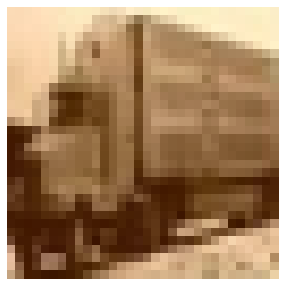

In [ ]:
show_image(min_max_scale(x[0]),figsize=(5,5));

In [ ]:
z = zca_block.fit(x)

In [ ]:
white_xb = z(x)

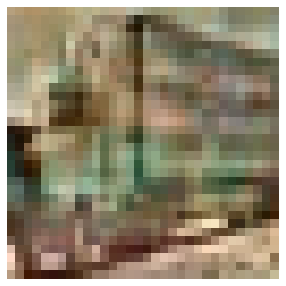

In [ ]:
show_image(min_max_scale(white_xb[0]),figsize=(5,5))